In [1]:
import numpy as np
import lqrpols
import matplotlib.pyplot as plt

In [2]:
# state transition matrices for linear system: 
#     x(t+1) = A x (t) + B u(t)
A = np.array([[1,1],[0,1]])
B = np.array([[0],[1]])
d,p = B.shape

# LQR quadratic cost per state
Q = np.array([[1,0],[0,0]])

# initial condition for system
z0 = -1 # initial position
v0 = 0  # initial velocity
x0 = np.vstack((z0,v0))

R = np.array([[1.0]])

# number of time steps to simulate
T = 10

# amount of Gaussian noise in dynamics
eq_err = 1e-2

In [3]:
N_vals = np.floor(np.logspace(0.0,2.4,num=6)).astype(int)
N_trials = 10

### Bunch of matrices for storing costs
J_finite_nom = np.zeros((N_trials,len(N_vals)))
J_finite_nomK = np.zeros((N_trials,len(N_vals)))
J_finite_rs = np.zeros((N_trials,len(N_vals)))
J_finite_ur = np.zeros((N_trials,len(N_vals)))
J_finite_pg = np.zeros((N_trials,len(N_vals)))
J_inf_nom = np.zeros((N_trials,len(N_vals)))
J_inf_rs = np.zeros((N_trials,len(N_vals)))
J_inf_ur = np.zeros((N_trials,len(N_vals)))
J_inf_pg = np.zeros((N_trials,len(N_vals)))


# cost for finite time horizon, true model
J_finite_opt = lqrpols.cost_finite_model(A,B,Q,R,x0,T,A,B)

### Solve for optimal infinite time horizon LQR controller
K_opt = -lqrpols.lqr_gain(A,B,Q,R)
# cost for infinite time horizon, true model
J_inf_opt = lqrpols.cost_inf_K(A,B,Q,R,K_opt) 

# cost for zero control
baseline = lqrpols.cost_finite_K(A,B,Q,R,x0,T,np.zeros((p,d)))/J_finite_opt-1;

# model for nominal control with 1 rollout
A_nom,B_nom = lqrpols.lsqr_estimator(A,B,Q,R,x0,eq_err,1,T)

# cost for finite time horizon, one rollout, nominal control
one_rollout_cost = lqrpols.cost_finite_model(A,B,Q,R,x0,T,A_nom,B_nom)/J_finite_opt-1;

for N in range(len(N_vals)):
    for trial in range(N_trials):
        
        # nominal model
        A_nom,B_nom = lqrpols.lsqr_estimator(A,B,Q,R,x0,eq_err,N_vals[N]*40,T);
        # finite time horizon cost with nominal model
        J_finite_nom[trial,N] = lqrpols.cost_finite_model(A,B,Q,R,x0,T,A_nom,B_nom)/J_finite_opt-1
        # Solve for infinite time horizon nominal LQR controller
        K_nom = -lqrpols.lqr_gain(A_nom,B_nom,Q,R)
        # cost of using the infinite time horizon solution for finite time horizon
        J_finite_nomK[trial,N] = lqrpols.cost_finite_K(A,B,Q,R,x0,T,K_nom)/J_finite_opt-1
        # infinite time horizon cost of nominal model
        J_inf_nom[trial,N] = lqrpols.cost_inf_K(A,B,Q,R,K_nom)/J_inf_opt-1

        # policy gradient
        K_pg = lqrpols.policy_gradient_linear_policy(A,B,Q,R,x0,eq_err,N_vals[N],T)
        J_finite_pg[trial,N] = lqrpols.cost_finite_K(A,B,Q,R,x0,T,K_pg)/J_finite_opt-1
        J_inf_pg[trial,N] = lqrpols.cost_inf_K(A,B,Q,R,K_pg)/J_inf_opt-1
        
        # random search
        K_rs = lqrpols.random_search_linear_policy(A,B,Q,R,x0,eq_err,N_vals[N]*5,T)
        J_finite_rs[trial,N] = lqrpols.cost_finite_K(A,B,Q,R,x0,T,K_rs)/J_finite_opt-1
        J_inf_rs[trial,N] = lqrpols.cost_inf_K(A,B,Q,R,K_rs)/J_inf_opt-1

        # uniformly random sampling
        K_ur = lqrpols.uniform_random_linear_policy(A,B,Q,R,x0,eq_err,N_vals[N]*40,T)
        J_finite_ur[trial,N] = lqrpols.cost_finite_K(A,B,Q,R,x0,T,K_ur)/J_finite_opt-1
        J_inf_ur[trial,N] = lqrpols.cost_inf_K(A,B,Q,R,K_ur)/J_inf_opt-1

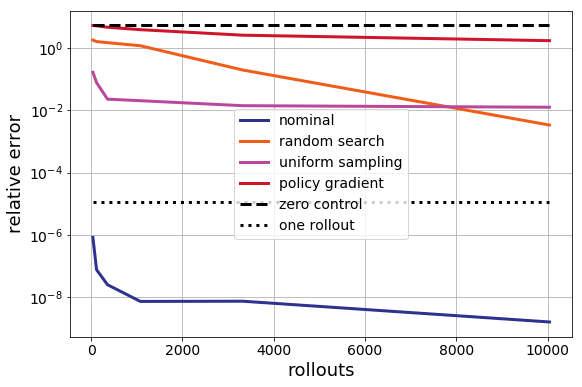

In [4]:
colors = [ '#2D328F', '#F15C19','#B9489D','#D0142B']

label_fontsize = 18
tick_fontsize = 14
linewidth = 3

plt.semilogy(40*N_vals,np.median(J_finite_nom,axis=0),color=colors[0],linewidth=linewidth,label='nominal')
plt.semilogy(40*N_vals,np.median(J_finite_rs,axis=0),color=colors[1],linewidth=linewidth,label='random search')
plt.semilogy(40*N_vals,np.median(J_finite_ur,axis=0),color=colors[2],linewidth=linewidth,label='uniform sampling')
plt.semilogy(40*N_vals,np.median(J_finite_pg,axis=0),color=colors[3],linewidth=linewidth,label='policy gradient')

plt.semilogy([40*N_vals[0],40*N_vals[-1]],[baseline, baseline],color='#000000',linewidth=linewidth,
             linestyle='--',label='zero control')
plt.semilogy([40*N_vals[0],40*N_vals[-1]],[one_rollout_cost, one_rollout_cost],color='#000000',linewidth=linewidth,
             linestyle=':',label='one rollout')

plt.xlabel('rollouts',fontsize=label_fontsize)
plt.ylabel('relative error',fontsize=label_fontsize)
plt.legend(fontsize=14)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

plt.grid(True)

fig = plt.gcf()
fig.set_size_inches(9, 6)

plt.show()